In [1028]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.optimize import curve_fit

To save vector figures (.svg), use the code `plt.savefig('example_figure.svg', format='eps')`

In [1029]:
def powerLaw(t, greek, A):
    return A*np.power(np.abs(t), greek)

def powerLawCorr(t, greek, A, C):
    return C + A*np.power(np.abs(t), greek)

def expCorr(x, xi, A, C):
    return C + A*np.exp(-x/xi)

def logCv(t, A, C):
    return A*np.log(np.abs(C*t))

Tc = 2/(np.log(1+np.sqrt(2)))

print(f'Critical temperature, Tc = {Tc:.6f}.')

beta0 = 0.125
gamma0 = 1.75
nu0 = 1

# Specify the full path to the font file
font_path = '/System/Library/Fonts/Supplemental/Times New Roman.ttf'

# Set the font family to 'lmodern'
plt.rcParams['font.family'] = plt.matplotlib.font_manager.FontProperties(fname=font_path).get_name()

Critical temperature, Tc = 2.269185.


/var/folders/pk/x0bc9zsx42l2vtpz9sfr5q5h0000gn/T/ipykernel_16024/3944560662.py:8: RuntimeWarning: overflow encountered in exp
  return C + A*np.exp(-x/xi)
/Users/wayne/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


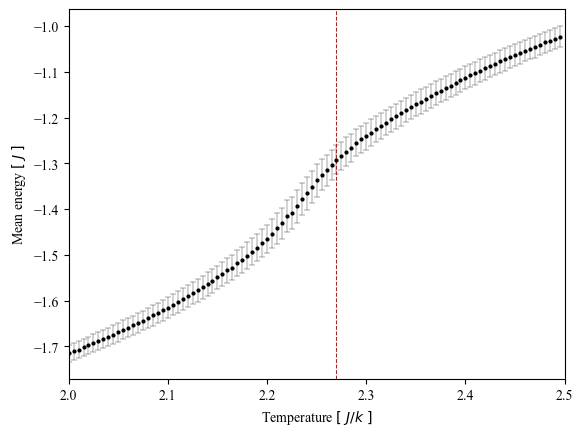

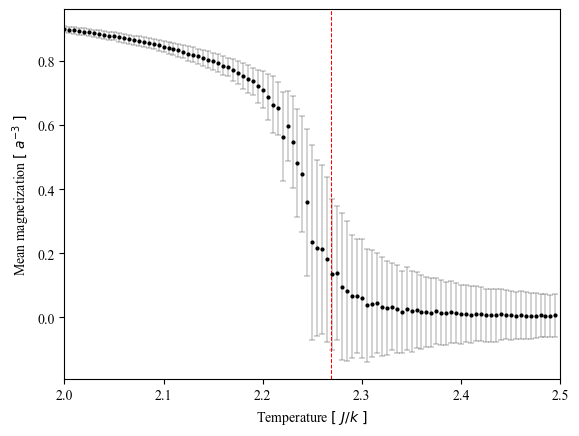

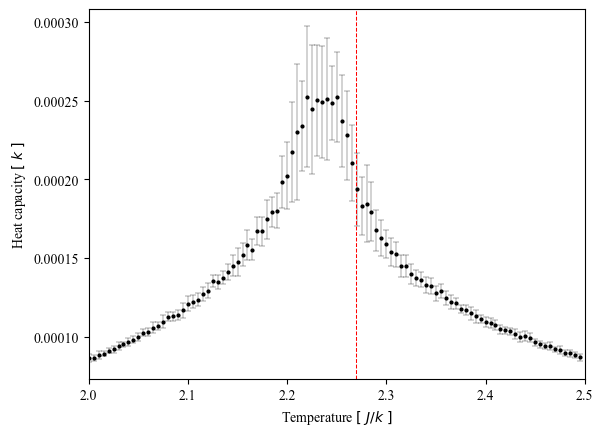

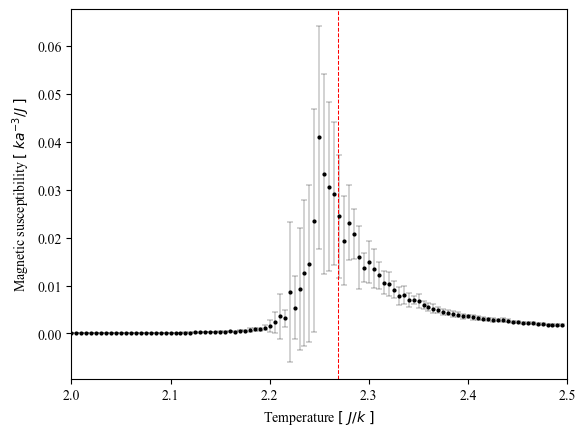

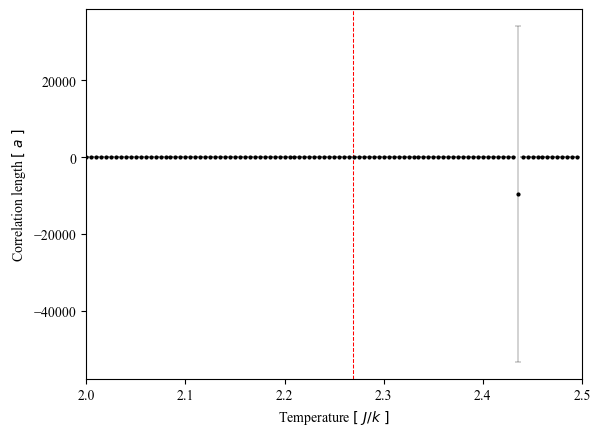

In [1030]:
filepath = 'data/final'
identifier = 'final_2.00T2.50'

version_min = 0
version_max = 21

# Initialize lists to store results
Temp = []
E_mean = []
E_std = []
M_mean = []
M_std = []

for ver in range(version_min, version_max + 1):
    version = str(ver)

    EMfilename = identifier + '_EM_v' + version + '.csv'

    EMfile = filepath + '/' + EMfilename

    # Read the CSV file, skipping the first three rows
    data = pd.read_csv(EMfile, skiprows=3)

    # Drop the first two rows
    # data = data.drop([0, 1, 2])

    # Convert columns to numeric
    data = data.apply(pd.to_numeric)

    Temp.append(data['Temp'].values.tolist())
    E_mean.append(data['E_mean'].values.tolist())
    E_std.append(data['E_std'].values.tolist())
    M_mean.append(np.abs(data['M_mean']).values.tolist())
    M_std.append(data['M_std'].values.tolist())

Temp = np.array(Temp)
E_mean = np.array(E_mean)
E_std = np.array(E_std)
M_mean = np.array(M_mean)
M_std = np.array(M_std)

Temp = np.mean(Temp, axis=0)
Emm = np.mean(E_mean, axis=0)
Ems = np.std(E_mean, axis=0)
Esm = np.mean(E_std, axis=0)
Ess = np.std(E_std, axis=0)
Mmm = np.mean(M_mean, axis=0)
Mms = np.std(M_mean, axis=0)
Msm = np.mean(M_std, axis=0)
Mss = np.std(M_std, axis=0)

xi = []

for ver in range(version_min, version_max + 1):
    version = str(ver)
    SCfilename = identifier + '_SC_v' + version + '.csv'

    SCfile = filepath + '/' + SCfilename

    # Read the CSV file, skipping the first four rows
    corr = pd.read_csv(SCfile, skiprows=4, header=None)

    # Drop the first three rows
    # data = data.drop([0, 1, 2])

    # Convert columns to numeric
    corr = corr.apply(pd.to_numeric)

    corr = corr.values

    d = np.arange(corr.shape[1] - 1) + 1

    xmax = 49

    xvals = np.linspace(0, xmax, 1000)

    xi0 = []

    plotting_spatial_corr = False    # change to 'True' if want to plot 

    for Tctr in range(Temp.size):
        try:
            exparams, expcov = curve_fit(expCorr, d, corr[Tctr, 1:])

            xcrit = int(np.floor(exparams[0]/1))

            if plotting_spatial_corr:
                print(f'T = {Temp[Tctr]:.4f}')
                print(f'xi = {exparams[0]:.4f}')

            if xcrit > 0 and False:
                params, pcov = curve_fit(powerLaw, d[0: xcrit + 1], corr[Tctr, 1:xcrit + 2])
                if plotting_spatial_corr:
                    plt.plot(xvals[xvals<=xcrit], powerLaw(xvals[xvals<=xcrit], *params), color='orange')
                    print(f'eta = {2-2-params[0]:.4f}')
            else:
                if plotting_spatial_corr:
                    print('Power law not fitted.')

            if plotting_spatial_corr:
                plt.scatter(d, corr[Tctr, 1:])

                plt.xlabel('x')
                plt.ylabel('R(x)')
                plt.plot(xvals, expCorr(xvals, *exparams), color='red')
                plt.title(f'T={corr[Tctr, 0]:.3f}')
                plt.show()

        except RuntimeError:
            exparams = (np.nan,)
            expcov = (np.nan,)
        
        xi0.append(exparams[0])

    xi.append(xi0)

xi = np.array(xi)

xim = np.mean(xi, axis=0)
xis = np.std(xi, axis=0)

# Plot E_mean vs Temp
# plt.figure(figsize=(10, 5))
plt.errorbar(Temp, Emm, yerr=Esm, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')    # yerr = Esm or yerr = Ems

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)    # yerr = Msm or yerr = Mms

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
# plt.ylim(0,6)

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Mean energy $[\ J\ ]$')
# plt.title('E_mean vs Temp')
plt.show()

# Plot M_mean vs Temp
# plt.figure(figsize=(10, 5))
plt.errorbar(Temp, Mmm, yerr=Msm, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
# plt.ylim(0,6)

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Mean magnetization $[\ a^{-3}\ ]$')
# plt.title('M_mean vs Temp')
plt.show()

# Calculate Cv
Cv = (Esm ** 2) / (Temp ** 2)
Cverr = 2*Cv*Ess/Esm

# Plot Cv vs Temp
# plt.figure(figsize=(10, 5))
plt.errorbar(Temp, Cv, yerr=Cverr, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
# plt.ylim(0,6)

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Heat capacity $[\ k\ ]$')
# plt.title('Specific Heat (Cv) vs Temp')
plt.show()

# Calculate chi
chi = (Msm ** 2) / Temp
chierr = 2*chi*Mss/Msm

# Plot chi vs Temp
# plt.figure(figsize=(10, 5))
plt.errorbar(Temp, chi, yerr=chierr, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
# plt.ylim(0,6)

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Magnetic susceptibility $[\ ka^{-3}/J\ ]$')
# plt.title('Magnetic Susceptibility (chi) vs Temp')
plt.show()

# Plot xi vs Temp
plt.errorbar(Temp, xim, yerr=xis, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
# plt.ylim(0,6)

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Correlation length $[\ a\ ]$')
plt.show()

In [1031]:
Tlo = Temp[Temp < Tc]
Thi = Temp[Temp > Tc]

tred = (Temp - Tc)/Tc

tlo = (Tlo - Tc)/Tc
thi = (Thi - Tc)/Tc

Mmmlo = Mmm[Temp < Tc]
Mmmhi = Mmm[Temp > Tc]

Mmslo = Mms[Temp < Tc]
Mmshi = Mms[Temp > Tc]

Msmlo = Msm[Temp < Tc]
Msmhi = Msm[Temp > Tc]

Msslo = Mss[Temp < Tc]
Msshi = Mss[Temp > Tc]

Emmlo = Emm[Temp < Tc]
Emmhi = Emm[Temp > Tc]

Emslo = Ems[Temp < Tc]
Emshi = Ems[Temp > Tc]

Esmlo = Esm[Temp < Tc]
Esmhi = Esm[Temp > Tc]

Esslo = Ess[Temp < Tc]
Esshi = Ess[Temp > Tc]

Cvlo = Cv[Temp < Tc]
Cvhi = Cv[Temp > Tc]

Cverrlo = Cverr[Temp < Tc]
Cverrhi = Cverr[Temp > Tc]

chilo = chi[Temp < Tc]
chihi = chi[Temp > Tc]

chierrlo = chierr[Temp < Tc]
chierrhi = chierr[Temp > Tc]

xilo = xim[Temp < Tc]
xihi = xim[Temp > Tc]

xierrlo = xis[Temp < Tc]
xierrhi = xis[Temp > Tc]

In [1032]:
Tmin = 2.00
Tmax = 2.50

Tmin1 = 2.15
Tmax1 = 2.39

Tmin1 = 2.25
Tmax1 = 2.29

# Tmin = 2.20
# Tmax = 2.34

# Tmin1 = Tc
# Tmax1 = Tc

beta = 0.13978143 +-0.00000079
Chi-square value: 179.381


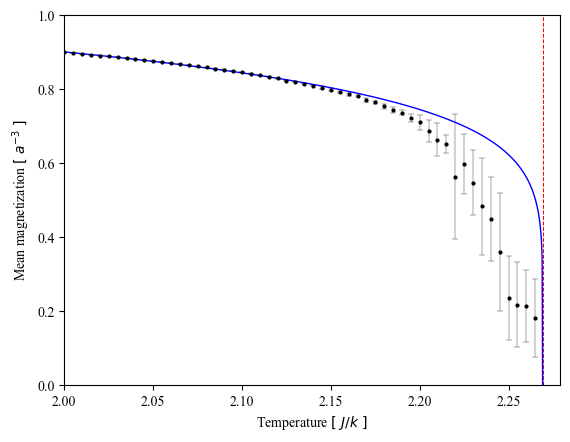

In [1033]:
tvals = np.linspace(Tmin, Tc, 1000)

mask = (Tmin <= Tlo) & (Tlo <= Tmin1)
p0 = [beta0, 1]
params, pcov, infodict, mesg, ier = curve_fit(powerLaw, tlo[mask], Mmmlo[mask], p0 = p0, sigma = Mmslo[mask], absolute_sigma = True, full_output = True)
print(f'beta = {params[0]:.8f} +-{pcov[0,0]:.8f}')

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.3f}')

# plt.figure(figsize=(10, 5))
mask = (Tmin <= Temp) & (Temp <= Tc)
plt.errorbar(Tlo[Tmin <= Tlo], Mmmlo[Tmin <= Tlo], yerr=Mms[mask], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, powerLaw((tvals-Tc)/Tc, *params), linewidth = 1, color = 'blue')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Mean magnetization $[\ a^{-3}\ ]$')

plt.xlim(Temp[0], Tc+0.01)
plt.ylim(0,1)

# plt.title('M_mean vs Temp')
plt.show()

(T<Tc) Chi-square value: 10.378
(Tc<T) Chi-square value: 6.061


/var/folders/pk/x0bc9zsx42l2vtpz9sfr5q5h0000gn/T/ipykernel_16024/3944560662.py:11: RuntimeWarning: divide by zero encountered in log
  return A*np.log(np.abs(C*t))


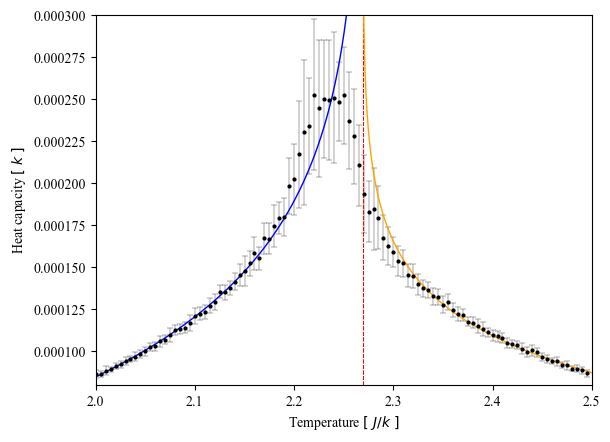

In [1034]:
tvals = np.linspace(Tmin, Tc, 1000)

mask = (Tmin <= Tlo) & (Tlo <= Tmin1)
params, pcov, infodict, mesg, ier = curve_fit(logCv, tlo[mask], Cvlo[mask], sigma = Cverrlo[mask], absolute_sigma = True, full_output = True)

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'(T<Tc) Chi-square value: {chi_sq:.3f}')

# plt.figure(figsize=(10, 5))
plt.errorbar(Tlo[Tmin <= Tlo], Cvlo[Tmin <= Tlo], yerr=Cverrlo[Tmin <= Tlo], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, logCv((tvals-Tc)/Tc, *params), linewidth = 1, color = 'blue')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Heat capacity $[\ k\ ]$')
# plt.title('M_mean vs Temp')

tvals = np.linspace(Tc, Tmax, 1000)

mask = (Thi <= Tmax) & (Tmax1 <= Thi)
params, pcov, infodict, mesg, ier = curve_fit(logCv, thi[mask], Cvhi[mask], sigma = Cverrhi[mask], absolute_sigma = True, full_output = True)

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'(Tc<T) Chi-square value: {chi_sq:.3f}')

# plt.figure(figsize=(10, 5))
plt.errorbar(Thi[Thi <= Tmax], Cvhi[Thi <= Tmax], yerr=Cverrhi[Thi <= Tmax], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, logCv((tvals-Tc)/Tc, *params), linewidth = 1, color = 'orange')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Heat capacity $[\ k\ ]$')
# plt.title('M_mean vs Temp')

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
plt.ylim(0.00008,0.0003)
plt.show()

(T<Tc) gamma = 2.3692 +-0.0040
Chi-square value: 4.75085
(Tc<T) gamma = 1.1229 +-0.0017
Chi-square value: 12.68971


/var/folders/pk/x0bc9zsx42l2vtpz9sfr5q5h0000gn/T/ipykernel_16024/3944560662.py:2: RuntimeWarning: divide by zero encountered in power
  return A*np.power(np.abs(t), greek)


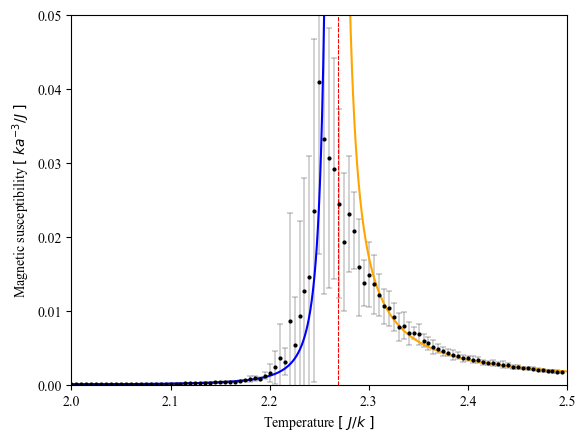

In [1035]:
tvals = np.linspace(Tmin, Tc, 1000)

mask = (Tmin <= Tlo) & (Tlo <= Tmin1)
p0 = [-gamma0, 1]
params, pcov, infodict, mesg, ier = curve_fit(powerLaw, tlo[mask], chilo[mask], p0 = p0, sigma = chierrlo[mask], absolute_sigma = True, full_output = True)
print(f'(T<Tc) gamma = {-params[0]:.4f} +-{pcov[0,0]:.4f}')

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.5f}')

# plt.figure(figsize=(10, 5))
plt.errorbar(Tlo[Tmin <= Tlo], chilo[Tmin <= Tlo], yerr=chierrlo[Tmin <= Tlo], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, powerLaw((tvals-Tc)/Tc, *params), color='blue')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Magnetic susceptibility $[\ ka^{-3}/J\ ]$')
# plt.title('M_mean vs Temp')

tvals = np.linspace(Tc, Tmax, 1000)

mask = (Thi <= Tmax) & (Tmax1 <= Thi)
p0 = [-gamma0, 1]
params, pcov, infodict, mesg, ier = curve_fit(powerLaw, thi[mask], chihi[mask], p0 = p0, sigma = chierrhi[mask], absolute_sigma = True, full_output = True)
print(f'(Tc<T) gamma = {-params[0]:.4f} +-{pcov[0,0]:.4f}')

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.5f}')

# plt.figure(figsize=(10, 5))
plt.errorbar(Thi[Thi <= Tmax], chihi[Thi <= Tmax], chierrhi[Thi <= Tmax], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, powerLaw((tvals-Tc)/Tc, *params), color='orange')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Magnetic susceptibility $[\ ka^{-3}/J\ ]$')
# plt.title('M_mean vs Temp')

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
plt.ylim(0,0.05)
plt.show()

(T<Tc) nu = 0.8474 +-0.0090
Chi-square value: 3.05266
(Tc<T) nu = 0.4834 +-0.0047
Chi-square value: 1.83109


/var/folders/pk/x0bc9zsx42l2vtpz9sfr5q5h0000gn/T/ipykernel_16024/3944560662.py:2: RuntimeWarning: divide by zero encountered in power
  return A*np.power(np.abs(t), greek)


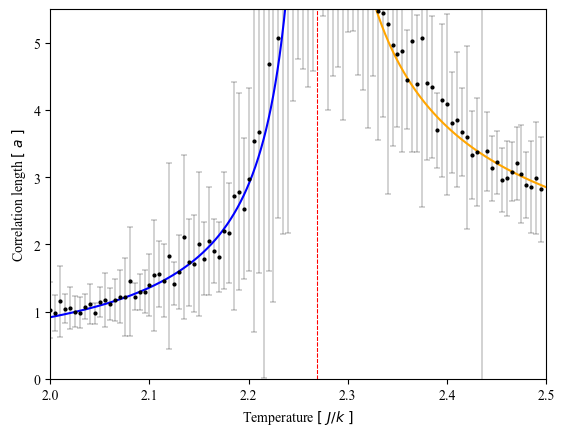

In [1036]:
tvals = np.linspace(Tmin, Tc, 1000)

mask = (Tmin <= Tlo) & (Tlo <= Tmin1)
p0 = [-nu0, 1]
params, pcov, infodict, mesg, ier = curve_fit(powerLaw, tlo[mask], xilo[mask], p0 = p0, sigma = xierrlo[mask], absolute_sigma = True, full_output = True)
print(f'(T<Tc) nu = {-params[0]:.4f} +-{pcov[0,0]:.4f}')

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.5f}')

# plt.figure(figsize=(10, 5))
plt.errorbar(Tlo[Tmin <= Tlo], xilo[Tmin <= Tlo], xierrlo[Tmin <= Tlo], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, powerLaw((tvals-Tc)/Tc, *params), color='blue')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Correlation length $[\ a\ ]$')
# plt.title('M_mean vs Temp')

tvals = np.linspace(Tc, Tmax, 1000)

mask = (Thi <= Tmax) & (Tmax1 <= Thi)
p0 = [-nu0, 1]
params, pcov, infodict, mesg, ier = curve_fit(powerLaw, thi[mask], xihi[mask], p0 = p0, sigma = xierrhi[mask], absolute_sigma = True, full_output = True)
print(f'(Tc<T) nu = {-params[0]:.4f} +-{pcov[0,0]:.4f}')

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.5f}')

# plt.figure(figsize=(10, 5))
plt.errorbar(Thi[Thi <= Tmax], xihi[Thi <= Tmax], xierrhi[Thi <= Tmax], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

plt.plot(tvals, powerLaw((tvals-Tc)/Tc, *params), color='orange')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Correlation length $[\ a\ ]$')
# plt.title('M_mean vs Temp')

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
plt.ylim(0,5.5)
plt.show()

Now we suppose Tc may not be the theoretical value.

In [1037]:
def powerLawTclo(t, greek, tc, A, C, Cslope, r):
    condition1 = t < tc - r
    condition2 = t >= tc -r
    result = np.zeros_like(t)  # Initialize result array

    # Assign values based on conditions
    result[condition1] = A * np.power(-(t[condition1] - tc), greek)
    result[condition2] = C + Cslope*t[condition2]

    return result

    # return np.piecewise(t, [t < tc, t >= tc], [lambda t: A * np.power(-(t - tc), greek), C])

def logCvTc(t, tc, Alo, Ahi, Clo, Chi, B, r):
    # return np.piecewise(t, [t < tc, t > tc, t == tc], [lambda t: A*np.log(-C*(t - tc)), A*np.log(C*(t - tc)), 0])
    # return np.piecewise(t, [t < tc, t > tc], [lambda t: A*np.log(-C*(t - tc)), A*np.log(C*(t - tc))])
    
    condition1 = t < tc - r
    condition2 = t > tc + r
    condition3 = (t > tc - r) & (t < tc + r)
    result = np.zeros_like(t)  # Initialize result array

    # Assign values based on conditions
    result[condition1] = Alo * np.log(-Clo * (t[condition1] - tc))
    result[condition2] = Ahi * np.log(Chi * (t[condition2] - tc))
    result[condition3] = B

    return result

def powerLawTc(t, greek, tc, Alo, Ahi, B, r):
    condition1 = t < tc - r
    condition2 = t > tc + r
    condition3 = (t > tc - r) & (t < tc + r)
    result = np.zeros_like(t)  # Initialize result array

    # Assign values based on conditions
    result[condition1] = Alo * np.power(-(t[condition1] - tc), greek)
    result[condition2] = Ahi * np.power((t[condition2] - tc), greek)
    result[condition3] = B

    return result

def powerLawTcCorr(t, greek, tc, Alo, Ahi, Clo, Chi, B, r):
    condition1 = t < tc - r
    condition2 = t > tc + r
    condition3 = (t > tc - r) & (t < tc + r)
    result = np.zeros_like(t)  # Initialize result array

    # Assign values based on conditions
    result[condition1] = Clo + Alo * np.power(-(t[condition1] - tc), greek)
    result[condition2] = Chi + Ahi * np.power((t[condition2] - tc), greek)
    result[condition3] = B

    return result

In [1038]:
Tmin = 2.00
Tmax = 2.50

Tmin1 = 2.15
Tmax1 = 2.39

Tmin1 = 2.25
Tmax1 = 2.29

# Tmin1 = 2.235
# Tmax1 = 2.29

# Tmin = 2.20
# Tmax = 2.34

Tmin1 = Tc
Tmax1 = Tc

beta = 0.1223 +-0.0039
beta percent error = -2.1663 +-3.1184
Tc = 2.2450 +-0.0051
Tc percent error = -1.0658 +-0.3898
Chi-square value: 122.094
Degrees of freedom: 6
Reduced chi-square value: 20.349


/var/folders/pk/x0bc9zsx42l2vtpz9sfr5q5h0000gn/T/ipykernel_16024/2891463236.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_inset.set_yticklabels([0.0, None, None, None, None, 1.0])
/var/folders/pk/x0bc9zsx42l2vtpz9sfr5q5h0000gn/T/ipykernel_16024/2891463236.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_inset.set_xticklabels([2.0, None, None, None, None, 2.5])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


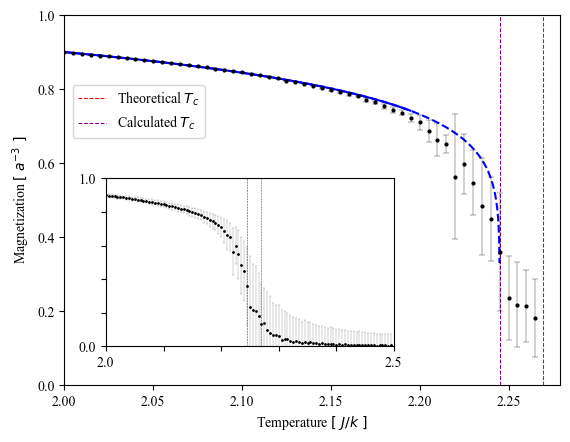

In [1039]:
tvals = np.linspace(Tmin, Tc, 1000)

# mask = (Tmin <= Tlo) & (Tlo <= Tmin1)
Tcrange = [2.2, 2.27]
max_excluded_range = 0.1

p0 = [beta0, 0, 1, 0, 0, max_excluded_range/Tc/2]
bounds = ([0, (Tcrange[0]-Tc)/Tc, -np.Inf, -np.Inf, -np.Inf, 0], [10, (Tcrange[1]-Tc)/Tc, np.Inf, np.Inf, np.Inf, max_excluded_range/Tc])
params, pcov, infodict, mesg, ier = curve_fit(powerLawTclo, tlo, Mmmlo, p0 = p0, sigma = Mmslo, absolute_sigma = True, full_output = True, bounds = bounds)
print(f'beta = {params[0]:.4f} +-{np.sqrt(pcov[0,0]):.4f}')
print(f'beta percent error = {(params[0]-beta0)/beta0*100:.4f} +-{100/beta0*np.sqrt(pcov[0,0]):.4f}')

r = params[-1]

newTc = Tc+Tc*params[1]
print(f'Tc = {newTc:.4f} +-{Tc*np.sqrt(pcov[1,1]):.4f}')
print(f'Tc percent error = {(newTc-Tc)/Tc*100:.4f} +-{100*np.sqrt(pcov[0,0]):.4f}')

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.3f}')
dof = 6
print(f'Degrees of freedom: {dof}')
print(f'Reduced chi-square value: {chi_sq/dof:.3f}')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75, label = r'Theoretical $T_c$')

# Plotting the vertical line
plt.axvline(x=newTc, color='purple', linestyle='--', linewidth=0.75, label = r'Calculated $T_c$')

plt.plot(tvals[tvals<newTc], powerLaw((tvals[tvals<newTc]-newTc)/Tc, params[0], params[2]), linewidth = 1.5, color = 'blue', linestyle = '--')
plt.plot(tvals[tvals<newTc-r*Tc], powerLaw((tvals[tvals<newTc-r*Tc]-newTc)/Tc, params[0], params[2]), linewidth = 1.5, color = 'blue')
# plt.plot(tvals[tvals<Tc], powerLawTclo((tvals[tvals<Tc]-Tc)/Tc, *params), linewidth = 1, color = 'orange')

# plt.figure(figsize=(10, 5))
mask = (Tmin <= Temp) & (Temp <= Tc)
plt.errorbar(Tlo[Tmin <= Tlo], Mmmlo[Tmin <= Tlo], yerr=Mms[mask], fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Magnetization $[\ a^{-3}\ ]$')

plt.xlim(Temp[0], Tc+0.01)
plt.ylim(0,1)

plt.legend(loc='center', bbox_to_anchor=(0.15, 0.74))
# plt.legend(loc = 'upper right')

# plt.title('M_mean vs Temp')

ax_inset = plt.axes([0.19, 0.19, 0.45, 0.35])  # [left, bottom, width, height]

ax_inset.errorbar(Temp, Mmm, yerr=Msm, fmt='o', markersize=1, capsize=1, capthick=0.125, elinewidth=0.125, color='black')

# Plotting the vertical line
ax_inset.axvline(x=Tc, color='r', linestyle='--', linewidth=0.375)

# Plotting the vertical line
ax_inset.axvline(x=newTc, color='purple', linestyle='--', linewidth=0.375)

ax_inset.set_xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
ax_inset.set_ylim(0, 1)

ax_inset.set_yticklabels([0.0, None, None, None, None, 1.0])
ax_inset.set_xticklabels([2.0, None, None, None, None, 2.5])

# plt.ylim(0,6)

# ax_inset.xlabel(r'Temperature $[\ J/k\ ]$')
# ax_inset.ylabel(r'Mean magnetization $[\ a^{-3}\ ]$')

plt.savefig('magnetization.eps', format='eps')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Chi-square value: 30.240
Degrees of freedom: 7
Reduced chi-square value: 4.320
Tc = 2.2398 +-0.0138
Tc percent error = -1.2928 +-0.6072


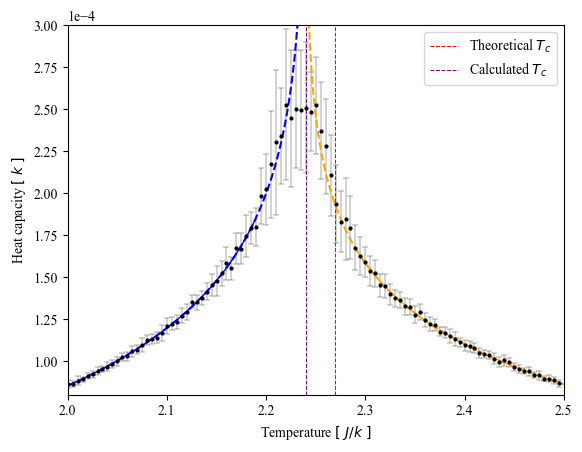

In [1040]:
tvals = np.linspace(Tmin, Tmax, 1000)

# mask = (Tmin <= Tlo) & (Tlo <= Tmax1)
Tcrange = [2.2, 2.27]
max_excluded_range = 0.1

p0 = [0, 1, 1, 1, 1, 0, max_excluded_range/Tc/2]
bounds = ([(Tcrange[0]-Tc)/Tc, -np.Inf, -np.Inf, -np.Inf, -np.Inf, -np.Inf, 0.001], [(Tcrange[1]-Tc)/Tc, np.Inf, np.Inf, np.Inf, np.Inf, np.Inf, 0.025])
params, pcov, infodict, mesg, ier = curve_fit(logCvTc, tred, Cv, p0 = p0, sigma = Cverr, absolute_sigma = True, full_output = True, bounds = bounds, maxfev = 100000)

r = params[-1]

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.3f}')
dof = 7
print(f'Degrees of freedom: {dof}')
print(f'Reduced chi-square value: {chi_sq/dof:.3f}')

newTc = Tc+Tc*params[0]
print(f'Tc = {newTc:.4f} +-{Tc*np.sqrt(pcov[0,0]):.4f}')
print(f'Tc percent error = {(newTc-Tc)/Tc*100:.4f} +-{100*np.sqrt(pcov[0,0]):.4f}')

# plt.figure(figsize=(10, 5))
plt.errorbar(Temp, Cv, yerr=Cverr, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75, label = r'Theoretical $T_c$')

# Plotting the vertical line
plt.axvline(x=newTc, color='purple', linestyle='--', linewidth=0.75, label = r'Calculated $T_c$')

mask1 = (tvals < newTc - r*Tc)
mask2 = (tvals > newTc + r*Tc)
mask1_1 = (tvals < newTc)
mask2_2 = (tvals > newTc)
plt.plot(tvals[mask1], logCvTc((tvals[mask1]-Tc)/Tc, *params), linewidth = 1, color = 'blue')
plt.plot(tvals[mask1_1], logCv((tvals[mask1_1]-newTc)/Tc, params[1], params[3]), linewidth = 1.5, color = 'blue', linestyle ='--')
plt.plot(tvals[mask2], logCvTc((tvals[mask2]-Tc)/Tc, *params), linewidth = 1, color = 'orange')
plt.plot(tvals[mask2_2], logCv((tvals[mask2_2]-newTc)/Tc, params[2], params[4]), linewidth = 1.5, color = 'orange', linestyle ='--')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Heat capacity $[\ k\ ]$')
# plt.title('M_mean vs Temp')

# Set scientific notation for y-tick labels
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
plt.ylim(0.00008,0.0003)

plt.legend(loc='upper right')

plt.savefig('heat_capacity.eps', format='eps')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


gamma = 1.6915 +-0.0410
gamma percent error = -3.3437 +-2.3407
Tc = 2.2400 +-0.0031
Tc percent error = -1.2862 +-0.1377
Chi-square value: 87.10778
Degrees of freedom: 6
Reduced chi-square value: 14.518


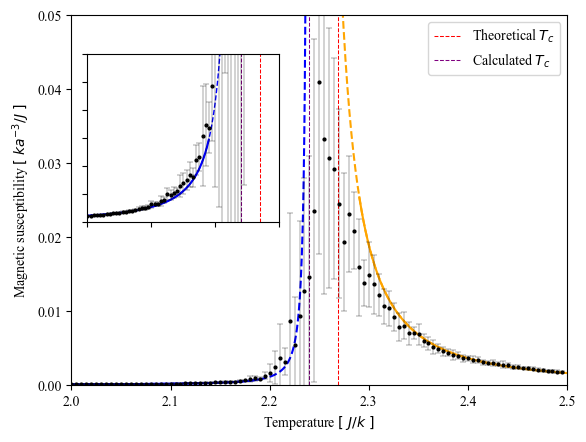

In [1041]:
tvals = np.linspace(Tmin, Tmax, 1000)

# mask = (Tmin <= Tlo) & (Tlo <= Tmin1)
Tcrange = [2.2, 2.27]
max_excluded_range = 0.1

p0 = [-gamma0, 0, 1, 1, 0, max_excluded_range/Tc/2]
bounds = ([-2, (Tcrange[0]-Tc)/Tc, -np.Inf, -np.Inf, -np.Inf, 0], [0, (Tcrange[1]-Tc)/Tc, np.Inf, np.Inf, np.Inf, max_excluded_range/Tc])
params, pcov, infodict, mesg, ier = curve_fit(powerLawTc, tred, chi, p0 = p0, sigma = chierr, absolute_sigma = True, full_output = True, bounds = bounds, ftol = 1e-14, maxfev = 100000)
print(f'gamma = {-params[0]:.4f} +-{np.sqrt(pcov[0,0]):.4f}')

print(f'gamma percent error = {(-params[0]-gamma0)/gamma0*100:.4f} +-{100/gamma0*np.sqrt(pcov[0,0]):.4f}')

r = params[-1]

newTc = Tc+Tc*params[1]
print(f'Tc = {newTc:.4f} +-{Tc*np.sqrt(pcov[1,1]):.4f}')
print(f'Tc percent error = {(newTc-Tc)/Tc*100:.4f} +-{100*np.sqrt(pcov[1,1]):.4f}')

r = params[-1]

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.5f}')
dof = 6
print(f'Degrees of freedom: {dof}')
print(f'Reduced chi-square value: {chi_sq/dof:.3f}')

# newTc = Tc+Tc*params[1]
# print(f'Tc = {newTc:.4f} +-{Tc*np.sqrt(pcov[1,1]):.4f}')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75, label = r'Theoretical $T_c$')

# Plotting the vertical line
plt.axvline(x=newTc, color='purple', linestyle='--', linewidth=0.75, label = r'Calculated $T_c$')

mask1 = (tvals < newTc - r*Tc)
mask2 = (tvals > newTc + r*Tc)
mask1_1 = (tvals < newTc)
mask2_2 = (tvals > newTc)
plt.plot(tvals[mask1], powerLawTc((tvals[mask1]-Tc)/Tc, *params), color='blue')
plt.plot(tvals[mask1_1], powerLaw((tvals[mask1_1]-newTc)/Tc, params[0], params[2]), linewidth = 1.5, color='blue', linestyle = '--')
plt.plot(tvals[mask2], powerLawTc((tvals[mask2]-Tc)/Tc, *params), color='orange')
plt.plot(tvals[mask2_2], powerLaw((tvals[mask2_2]-newTc)/Tc, params[0], params[3]), linewidth = 1.5, color='orange', linestyle = '--')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Magnetic susceptibility $[\ ka^{-3}/J\ ]$')
# plt.title('M_mean vs Temp')

# plt.figure(figsize=(10, 5))
plt.errorbar(Temp, chi, yerr=chierr, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
plt.ylim(0,0.05)
# plt.show()
main_aspect = plt.gca().get_aspect()

plt.legend(loc='upper right')

'''
inset time
'''

ax_inset = plt.axes([0.15, 0.45, 0.3, 0.35], aspect=main_aspect)  # [left, bottom, width, height]

# Plotting the vertical line
ax_inset.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75)

# Plotting the vertical line
ax_inset.axvline(x=newTc, color='purple', linestyle='--', linewidth=0.75)

mask1 = (tvals < newTc - r*Tc)
mask2 = (tvals > newTc + r*Tc)
mask1_1 = (tvals < newTc)
mask2_2 = (tvals > newTc)
ax_inset.plot(tvals[mask1], powerLawTc((tvals[mask1]-Tc)/Tc, *params), color='blue')
ax_inset.plot(tvals[mask1_1], powerLaw((tvals[mask1_1]-newTc)/Tc, params[0], params[2]), linewidth = 1, color='blue', linestyle = '--')
ax_inset.plot(tvals[mask2], powerLawTc((tvals[mask2]-Tc)/Tc, *params), color='orange')
ax_inset.plot(tvals[mask2_2], powerLaw((tvals[mask2_2]-newTc)/Tc, params[0], params[3]), linewidth = 1, color='orange', linestyle = '--')

# plt.title('M_mean vs Temp')

# plt.figure(figsize=(10, 5))
ax_inset.errorbar(Temp, chi, yerr=chierr, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

# ax_inset.xlabel(r'Temperature $[\ J/k\ ]$')
# ax_inset.ylabel(r'Magnetic susceptibility $[\ ka^{-3}/J\ ]$')
# plt.title('M_mean vs Temp')

ax_inset.set_yticklabels([])
ax_inset.set_xticklabels([])

ax_inset.set_xlim(Temp[0], 2.3)
ax_inset.set_ylim(0,0.0015)

plt.savefig('magnetic_susceptibility.eps', format='eps')

plt.show()

nu = 0.9437 +-0.6271
nu percent error = -5.6315 +-62.7071
Tc = 2.2399999920 +-0.0000000366
Tc percent error = -1.2861586043 +-0.0000016108
Chi-square value: 20.63376
Degrees of freedom: 6
Reduced chi-square value: 3.439


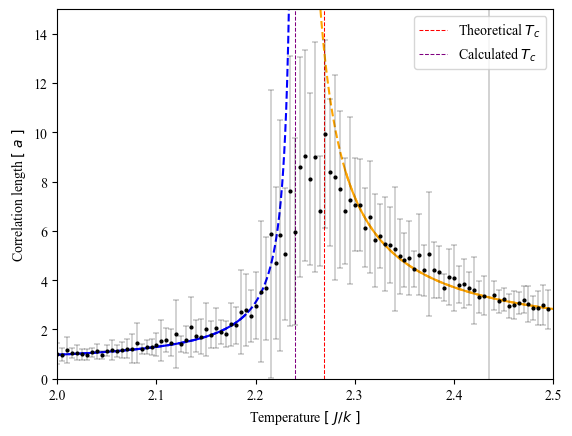

In [1042]:
tvals = np.linspace(Tmin, Tmax, 1000)

# mask = (Tmin <= Tlo) & (Tlo <= Tmin1)
Tcrange = [2.2, 2.27]
max_excluded_range = 0.1 # 0.1
Tcguess = 2.24

p0 = [-nu0, (Tcguess - Tc)/Tc, 1, 1, 0, 0, 0, max_excluded_range/Tc/2]
bounds = ([-1.2, (Tcrange[0]-Tc)/Tc, -np.Inf, -np.Inf, -np.Inf, -np.Inf, -np.Inf, 0], [-0.8, (Tcrange[1]-Tc)/Tc, np.Inf, np.Inf, np.Inf, np.Inf, np.Inf, max_excluded_range/Tc])
params, pcov, infodict, mesg, ier = curve_fit(powerLawTcCorr, tred, xim, p0 = p0, sigma = xis, absolute_sigma = True, full_output = True, bounds = bounds, ftol = 1e-15, maxfev = 100000)
print(f'nu = {-params[0]:.4f} +-{np.sqrt(pcov[0,0]):.4f}')

print(f'nu percent error = {(-params[0]-nu0)/nu0*100:.4f} +-{100/nu0*np.sqrt(pcov[0,0]):.4f}')

# r = params[-1]

newTc = Tc+Tc*params[1]
print(f'Tc = {newTc:.10f} +-{Tc*np.sqrt(pcov[1,1]):.10f}')
print(f'Tc percent error = {(newTc-Tc)/Tc*100:.10f} +-{100*np.sqrt(pcov[1,1]):.10f}')

r = params[-1]

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.5f}')
dof = 6
print(f'Degrees of freedom: {dof}')
print(f'Reduced chi-square value: {chi_sq/dof:.3f}')

# newTc = Tc+Tc*params[1]
# print(f'Tc = {newTc:.10f} +-{Tc*np.sqrt(pcov[1,1]):.10f}')

# Plotting the vertical line
plt.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75, label = r'Theoretical $T_c$')

# Plotting the vertical line
plt.axvline(x=newTc, color='purple', linestyle='--', linewidth=0.75, label = r'Calculated $T_c$')

mask1 = (tvals < newTc - r*Tc)
mask2 = (tvals > newTc + r*Tc)
mask1_1 = (tvals < newTc)
mask2_2 = (tvals > newTc)
plt.plot(tvals[mask1], powerLawTcCorr((tvals[mask1]-Tc)/Tc, *params), linewidth = 1.5, color='blue')
plt.plot(tvals[mask1_1], powerLawCorr((tvals[mask1_1]-newTc)/Tc, params[0], params[2], params[4]), linewidth = 1.5, color='blue', linestyle = '--')
plt.plot(tvals[mask2], powerLawTcCorr((tvals[mask2]-Tc)/Tc, *params), linewidth = 1.5, color='orange')
plt.plot(tvals[mask2_2], powerLawCorr((tvals[mask2_2]-newTc)/Tc, params[0], params[3], params[5]), linewidth = 1.5, color='orange', linestyle = '--')

# plt.plot(tvals, powerLaw((tvals-Tc)/Tc, *params), color='blue')

# plt.figure(figsize=(10, 5))
plt.errorbar(Temp, xim, xis, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

plt.xlabel(r'Temperature $[\ J/k\ ]$')
plt.ylabel(r'Correlation length $[\ a\ ]$')
# plt.title('M_mean vs Temp')

plt.xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
plt.ylim(0,15) # (0, 5.5)

plt.legend(loc='upper right')

plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Temperature = 2.270
Correlation length, xi = 9.9377 +-3.8244
eta = -0.0002 +-1.6096
Chi-square value: 0.01181
Degrees of freedom: 2
Reduced chi-square value: 0.006
nu = 0.9437 +-0.6271
Chi-square value: 20.63376
Degrees of freedom: 6
Reduced chi-square value: 3.439
Tc = 2.2399999920 +-0.0000000366
Tc percent error = -1.2861586043 +-0.0000016108


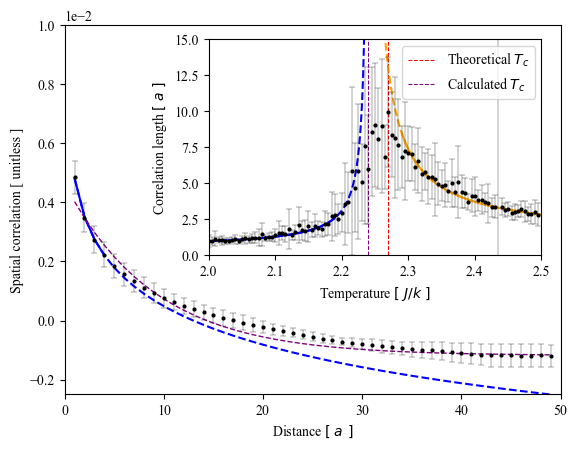

In [1043]:
temp_index = np.where(np.abs(Temp - 2.27) < 0.00001)[0][0]

spatialCorr = []
spatialA = []
spatialC = []

for ver in range(version_min, version_max + 1):
    version = str(ver)
    SCfilename = identifier + '_SC_v' + version + '.csv'

    SCfile = filepath + '/' + SCfilename

    # Read the CSV file, skipping the first four rows
    corr = pd.read_csv(SCfile, skiprows=4, header=None)

    # Drop the first three rows
    # data = data.drop([0, 1, 2])

    # Convert columns to numeric
    corr = corr.apply(pd.to_numeric)

    corr = corr.values

    spatialCorr.append(corr[temp_index, 1:])

    exparams, expcov = curve_fit(expCorr, d, corr[temp_index, 1:])

    spatialA.append(exparams[1])
    spatialC.append(exparams[2])

NDspatialCorr = np.array(spatialCorr)
NDspatialA = np.array(spatialA)
NDspatialC = np.array(spatialC)

spatialCorr_mean = np.mean(NDspatialCorr, axis = 0)
spatialCorr_std = np.std(NDspatialCorr, axis = 0)

our_A = np.mean(NDspatialA)
our_C = np.mean(NDspatialC)

d = np.arange(corr.shape[1] - 1) + 1

print(f'Temperature = {Temp[temp_index]:.3f}')

print(f'Correlation length, xi = {xim[temp_index]:.4f} +-{xis[temp_index]:.4f}')

our_xi = int(np.floor(xim[temp_index]))
d_upto = our_xi/2

# p0 = [0, 1, 1, 1, 1, 0, max_excluded_range/Tc/2]
# bounds = ([(Tcrange[0]-Tc)/Tc, -np.Inf, -np.Inf, -np.Inf, -np.Inf, -np.Inf, 0.001], [(Tcrange[1]-Tc)/Tc, np.Inf, np.Inf, np.Inf, np.Inf, np.Inf, 0.025])
params, pcov, infodict, mesg, ier = curve_fit(powerLawCorr, d[d<d_upto], spatialCorr_mean[d<d_upto], sigma = spatialCorr_std[d<d_upto], absolute_sigma = True, full_output = True, maxfev = 100000)

print(f'eta = {-params[0]:.4f} +-{np.sqrt(pcov[0,0]):.4f}')

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.5f}')
dof = 2
print(f'Degrees of freedom: {dof}')
print(f'Reduced chi-square value: {chi_sq/dof:.3f}')

plt.plot(d[d<d_upto], powerLawCorr(d[d<d_upto], *params), linewidth = 1.5, color='blue')
plt.plot(d, powerLawCorr(d, *params), linewidth = 1.5, color='blue', linestyle = '--')

plt.plot(d, expCorr(d, our_xi, our_A, our_C), linewidth = 1, color='purple', linestyle = '--')

plt.errorbar(d, spatialCorr_mean, spatialCorr_std, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

plt.xlabel(r'Distance $[\ a\ ]$')
plt.ylabel(r'Spatial correlation [ unitless ]')
# plt.title('M_mean vs Temp')

# Set scientific notation for y-tick labels
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlim(0, 50)
plt.ylim(-0.0025,0.01) # (0, 5.5)

'''
inset
'''

ax_inset = plt.axes([0.35, 0.4, 0.52, 0.45])  # [left, bottom, width, height]

tvals = np.linspace(Tmin, Tmax, 1000)

# mask = (Tmin <= Tlo) & (Tlo <= Tmin1)
Tcrange = [2.2, 2.27]
max_excluded_range = 0.1 # 0.1
Tcguess = 2.24

p0 = [-nu0, (Tcguess - Tc)/Tc, 1, 1, 0, 0, 0, max_excluded_range/Tc/2]
bounds = ([-1.2, (Tcrange[0]-Tc)/Tc, -np.Inf, -np.Inf, -np.Inf, -np.Inf, -np.Inf, 0], [-0.8, (Tcrange[1]-Tc)/Tc, np.Inf, np.Inf, np.Inf, np.Inf, np.Inf, max_excluded_range/Tc])
params, pcov, infodict, mesg, ier = curve_fit(powerLawTcCorr, tred, xim, p0 = p0, sigma = xis, absolute_sigma = True, full_output = True, bounds = bounds, ftol = 1e-15, maxfev = 100000)
print(f'nu = {-params[0]:.4f} +-{np.sqrt(pcov[0,0]):.4f}')

r = params[-1]

# Calculate the chi-square value
chi_sq = np.sum((infodict["fvec"])**2)

print(f'Chi-square value: {chi_sq:.5f}')
dof = 6
print(f'Degrees of freedom: {dof}')
print(f'Reduced chi-square value: {chi_sq/dof:.3f}')

newTc = Tc+Tc*params[1]
print(f'Tc = {newTc:.10f} +-{Tc*np.sqrt(pcov[1,1]):.10f}')
print(f'Tc percent error = {(newTc-Tc)/Tc*100:.10f} +-{100*np.sqrt(pcov[1,1]):.10f}')

# Plotting the vertical line
ax_inset.axvline(x=Tc, color='r', linestyle='--', linewidth=0.75, label = r'Theoretical $T_c$')

# Plotting the vertical line
ax_inset.axvline(x=newTc, color='purple', linestyle='--', linewidth=0.75, label = r'Calculated $T_c$')

mask1 = (tvals < newTc - r*Tc)
mask2 = (tvals > newTc + r*Tc)
mask1_1 = (tvals < newTc)
mask2_2 = (tvals > newTc)
ax_inset.plot(tvals[mask1], powerLawTcCorr((tvals[mask1]-Tc)/Tc, *params), linewidth = 1.5, color='blue')
ax_inset.plot(tvals[mask1_1], powerLawCorr((tvals[mask1_1]-newTc)/Tc, params[0], params[2], params[4]), linewidth = 1.5, color='blue', linestyle = '--')
ax_inset.plot(tvals[mask2], powerLawTcCorr((tvals[mask2]-Tc)/Tc, *params), linewidth = 1.5, color='orange')
ax_inset.plot(tvals[mask2_2], powerLawCorr((tvals[mask2_2]-newTc)/Tc, params[0], params[3], params[5]), linewidth = 1.5, color='orange', linestyle = '--')

# plt.plot(tvals, powerLaw((tvals-Tc)/Tc, *params), color='blue')

# plt.figure(figsize=(10, 5))
ax_inset.errorbar(Temp, xim, xis, fmt='o', markersize=2, capsize=2, capthick=0.25, elinewidth=0.25, color='black')

ax_inset.set_xlabel(r'Temperature $[\ J/k\ ]$')
ax_inset.set_ylabel(r'Correlation length $[\ a\ ]$')
# plt.title('M_mean vs Temp')

ax_inset.set_xlim(Temp[0], Temp[-1] + (Temp[-1]-Temp[0])/(Temp.size-1))
ax_inset.set_ylim(0,15) # (0, 5.5)

plt.legend(loc='upper right')

plt.savefig('spatial_correlation_length.eps', format='eps')

plt.show()